# Convolutional Neural Networks
---

* 이번 학습에서는 image classification을 위한 **CNN**을 구현하고 training 시키는 방법에 대한 학습을 하도록 하겠습니다
  * MNIST와 비슷하게, CIFAR-10은 image를 10개의 class로 classify하는 문제의 입문 dataset으로 널리 사용됩니다. 
  * 특히, CNN에 대해서 배울때 많이 활용되죠
  * 이미지의 크기는 32x32x3으로 흑백이 아닌 color image 입니다
* 10개의 class와 image에 대한 예제입니다:


![alt text](https://drive.google.com/uc?export=view&id=13XrhBYgNC2BbZMEiQ6aaKXlpuwj3MU5I)

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

* 지난 시간과 마찬가지로, cuda를 이용하겠습니다


In [ ]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

* 아미지를 다운로드 받습니다
* 아래 코드는 training set을 training과 validation set으로 분할 합니다
* 각 training, validation, test set에 대한 DataLoader를 생성합니다


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# batch size
batch_size = 20
# training set 중에서 validation set으로 분할 할 비율 
valid_size = 0.2

# Transform 정의 (3개 channel (RGB)인 것을 잊지 마세요)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
# Normalize 하는 이유 : 본인이 설계한 network 이 최적화(gredient 등)가 잘 되도록
# 데이터를 변형하기 위함  , 평균이 0이되고 표준편차가 1이 되게끔 변형할 경우
# 대체적으로 잘 동작 , 0.5를빼고 0.5를 나눔 (순서가 중요) ) 채널별로 구분


# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# validation 분할하기, 아래 코드 하나씩 찍어보시고 무엇을 하는지 확인해보세요
# validation set 과 test set을 분할 ,랜덤하게 만들기 위한 작업
num_train = len(train_data)
indices = list(range(num_train)) # 0 ~ 49999 까지 
np.random.shuffle(indices) # 무작위로 섞어줌
split = int(np.floor(valid_size * num_train)) # 0.2(valid_size) * 50000(num_train) = 10000, 소수점이 될 수 있으므로 floor 로 내림
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
# data loader 로 넣을수 있는 자료구조로 변환 하는 작업
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
num_train

50000

In [ ]:
train_sampler 
# SubsetRandomSampler라는 오브젝트

### 한개의 Training Data batch 보기

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize (채널별로 다를 경우 채널별로 계산)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

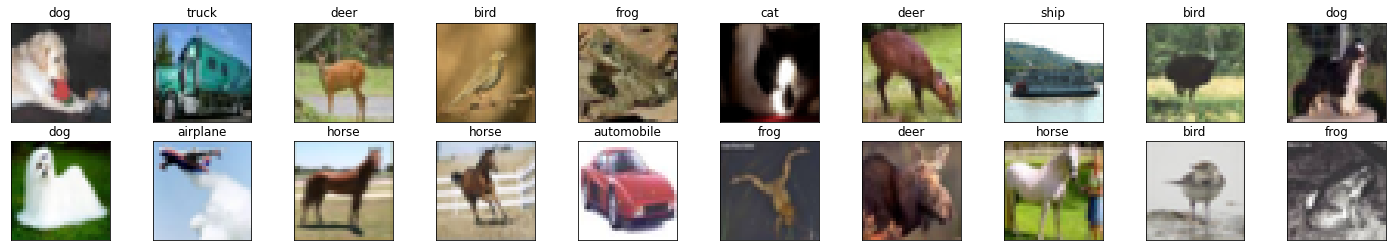

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
images.shape
# 20개의 batch, 채널이 맨 앞에

(20, 3, 32, 32)

In [ ]:
np.min(images)

-1.0

In [ ]:
np.min(images/2+0.5)

0.0

In [ ]:
np.max(images)

1.0

In [ ]:
np.max(images/2+0.5)

1.0

### View an Image in More Detail

* Image의 저장된 방법을 조금 더 자세하게 살펴보죠
* 아래 코드는 각 이미지의 값을 RGB channel 별로 흑백으로 값을 표현한 것 입니다

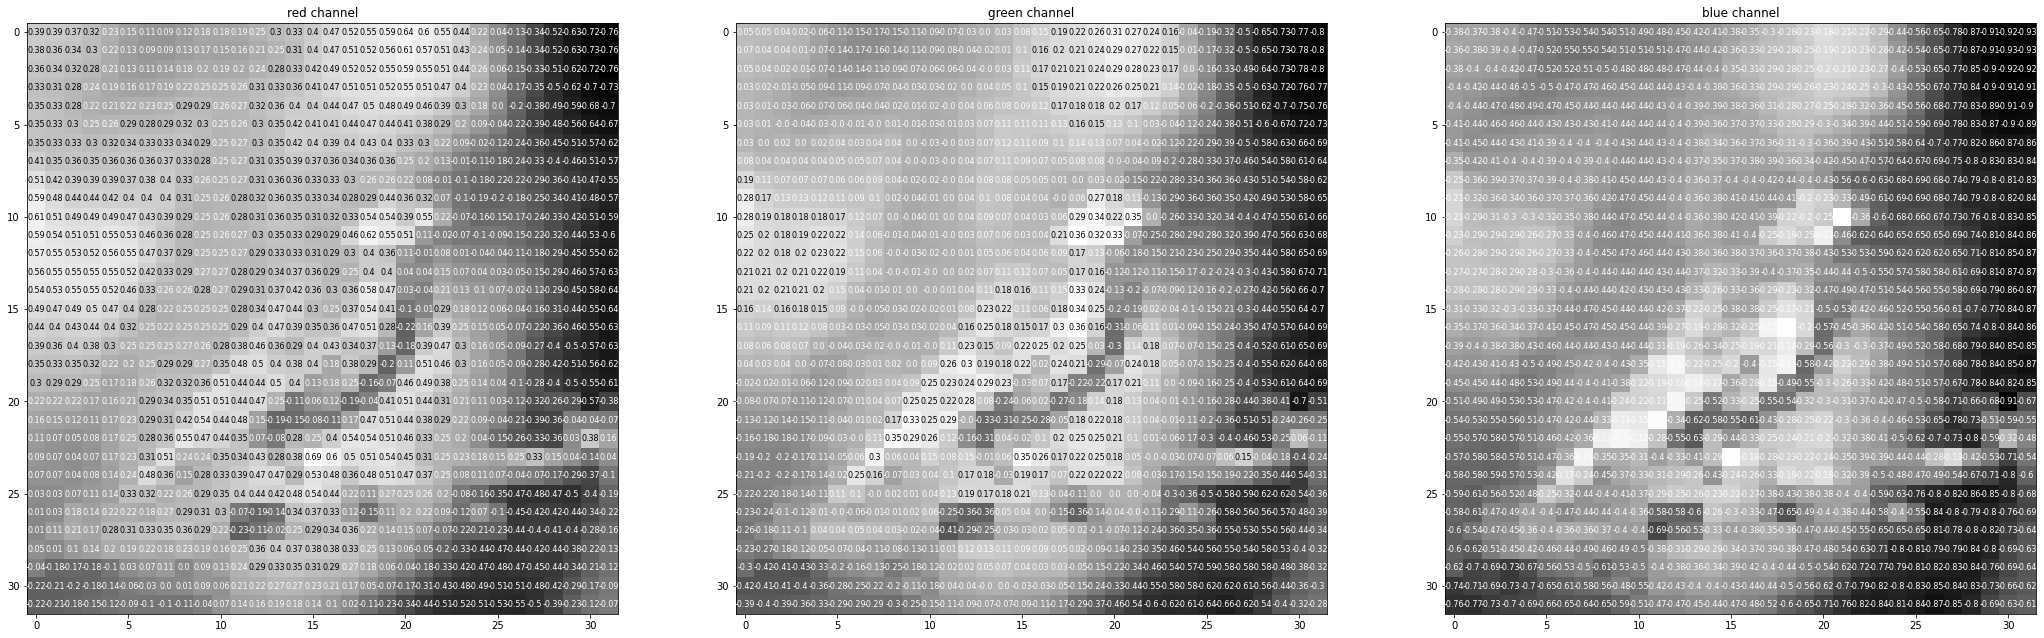

In [ ]:
rgb_img = images[3]
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [ ]:
images[3].shape

(3, 32, 32)

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)


* 아래 학습에서는 CNN 구조를 정의하는 방법을 학습합니다
* Fully connected layer와 함께 convolutional layer와 maxpooling layer을 활용하도록 합니다:
  * [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d)
  * [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d)
  * Fully connected layer: Linear + activation + Dropout layers를 활용하여 10개의 classification output 생성

```
  Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
  
  torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
```

아래 그림은 2개의 convolutional layer로 구성된 네트워크입니다
![alt text](https://drive.google.com/uc?export=view&id=1lXQzTYnYOAaQBDqpv-e3wZCk8HtFKOMw)


#### Exercise 1 [20점]

* 여러개의 convolutional layer와 feedforward layer을 활용하여 분류 네트워크를 완성하세요

* Convolutional layer가 많을 수록, 그림의 다양한 패턴을 관찰하면서 특성을 파악합니다
* 최소 2개에서 3개의 convolutional layer을 활용하기를 추천합니다
* FC layer는 dropout을 활용하고, relu를 활용합니다
* 최종 layer는 logsoftmax를 하던가, linear layer와 crossentropy loss를 활요하는 것은 자유입니다


* 본 문제를 코딩한 예입니다: [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py)

#### Output volume for a convolutional layer

* 주의해야 할 부분은 각 convolutional layer와 maxpool을 계산하는데 각 layer별로 차원을 잘 맞춰줘야 합니다!

* 자유롭게 모델을 완성하고 성능을 측정하면서, 최대한 성능을 높여보세요

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        #layer들을 정의하는 함수
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        # input 채널 3, 16개의 필터사용, 3x3 커널 padding 1 은 항상 같은 차원을 유지
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        # 위에서 16개의 채널을 사용 했으므로 input size 유지, 16개 채널 들어감 32개 채널로 변환
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        # 마찬가지로 32개의 채널 들어가고 64 채널로 변환 필터크기 똑같이 유지
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500) # linear input 은 64 * 4 * 4 , 500개의 출력으로 바꿈
        # linear layer (500 -> 10) 
        self.fc2 = nn.Linear(500, 10) # 최종 출력이 10개이므로 바꿈
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        #layer들을 어떻게 적용할지 정함
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x))) # relu를 하고 maxpool을 함
        x = self.pool(F.relu(self.conv2(x))) # relu를 하고 maxpool을 함
        x = self.pool(F.relu(self.conv3(x))) # relu를 하고 maxpool을 함 4 x 4 x 64 가 되어 있을것임
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.log_softmax(self.fc2(x),dim=1)
        
        return x

# create a complete CNN
model = Net() # model이라는 인스턴스 생성
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)


In [ ]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

* training loss와 validation loss를 비교해보면서, 진행과정을 관찰합니다
* 만약 validation loss가 증가하거나 정체되었다면 overfitting의 가능성이 높습니다

In [ ]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # data.size(batch 사이즈)를 곱하는 이유는 loss.item 은 batch의 batch사이즈로 평균을 냄
        # 여기서 datasize를 곱해줘야함
        # 나중에 전체 데이터 사이즈로 나눠야 평균을 낼 수 있음
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler) # .sampler를 해야 4만개가 나옴
    valid_loss = valid_loss/len(valid_loader.sampler) # 마찬가지로 1만개 나옴
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.100375 	Validation Loss: 1.787786
Validation loss decreased (inf --> 1.787786).  Saving model ...
Epoch: 2 	Training Loss: 1.642734 	Validation Loss: 1.492283
Validation loss decreased (1.787786 --> 1.492283).  Saving model ...
Epoch: 3 	Training Loss: 1.426133 	Validation Loss: 1.393535
Validation loss decreased (1.492283 --> 1.393535).  Saving model ...
Epoch: 4 	Training Loss: 1.293716 	Validation Loss: 1.235199
Validation loss decreased (1.393535 --> 1.235199).  Saving model ...
Epoch: 5 	Training Loss: 1.183299 	Validation Loss: 1.153018
Validation loss decreased (1.235199 --> 1.153018).  Saving model ...
Epoch: 6 	Training Loss: 1.087274 	Validation Loss: 1.044844
Validation loss decreased (1.153018 --> 1.044844).  Saving model ...
Epoch: 7 	Training Loss: 1.008793 	Validation Loss: 1.065537
Epoch: 8 	Training Loss: 0.942407 	Validation Loss: 0.956175
Validation loss decreased (1.044844 --> 0.956175).  Saving model ...
Epoch: 9 	Training Loss: 0.884525 

###  Validation Loss가 최소화된 Model가져오기

In [ ]:
model.load_state_dict(torch.load('model_cifar.pt'))
# 제일 좋았던 모델로 로딩

<All keys matched successfully>

---
## Test the Trained Network

* Test set을 활용하여 성능 검증
* 잘 되었다면 70% 이상의 성공률이 가능할 것 같습니다
* 다양한 변화를 줘서 최대한 좋은 성공률을 달성해보세요

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # train 한 gpu가 아니면 앞에 있는 코드 수행, gpu면 else문 수행 (cpu로 옮긴후 numpy)

    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.829835

Test Accuracy of airplane: 76% (762/1000)
Test Accuracy of automobile: 85% (858/1000)
Test Accuracy of  bird: 56% (569/1000)
Test Accuracy of   cat: 45% (451/1000)
Test Accuracy of  deer: 68% (688/1000)
Test Accuracy of   dog: 73% (734/1000)
Test Accuracy of  frog: 76% (765/1000)
Test Accuracy of horse: 77% (774/1000)
Test Accuracy of  ship: 83% (833/1000)
Test Accuracy of truck: 81% (816/1000)

Test Accuracy (Overall): 72% (7250/10000)


### Visualize Sample Test Results

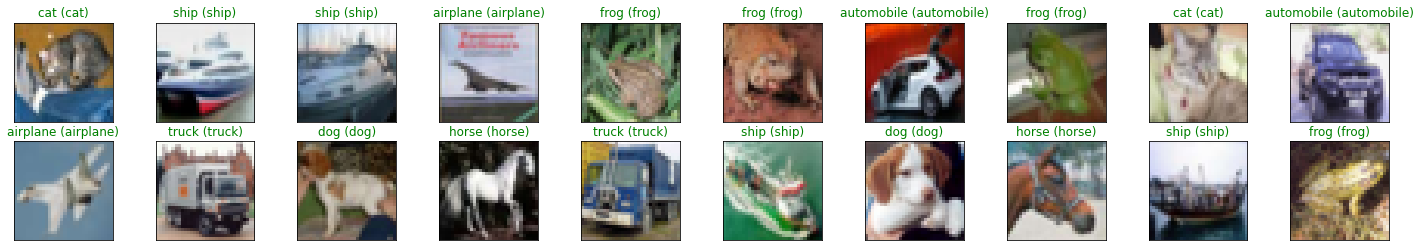

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))